<a href="https://colab.research.google.com/github/amandasbassani/Notebooks_Visao_Computacional/blob/main/T3_Vis%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T3 - Reconstrução da posição 3D de um robô móvel (Visão Computacional - 2022/1)

Amanda Schneider Bassani

## Pacotes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.5 MB 87 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.7 MB 105 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [3]:
import cv2
import numpy as np
from cv2 import aruco
import matplotlib.pyplot as plt
import sys
from google.colab.patches import cv2_imshow
import json

## Arquivos de entrada

In [4]:
video00 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/camera-00.mp4"
video01 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/camera-01.mp4"
video02 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/camera-02.mp4"
video03 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/camera-03.mp4"

data00 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/0.json"
data01 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/1.json"
data02 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/2.json"
data03 = "/content/drive/MyDrive/Visão Computacional/Trabalho 3/3.json"

## Funções

In [5]:
def extract_parameters(file_name):
    ''' Extrai dos arquivos .json os parâmetros intrínsecos e extrínsecos da câmera '''
    with open(file_name) as file:
        data = json.load(file)
    intrinsic = np.reshape(data["intrinsic"]["doubles"],(3,3))
    extrinsic = np.linalg.inv(np.reshape(data["extrinsic"]["tf"]["doubles"],(4,4)))
    return intrinsic, extrinsic


In [6]:
def detect_markers(file_name): 
    ''' Retorna matriz de pontos onde foi detectado o aruco frame a frame '''
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
    parameters =  aruco.DetectorParameters_create()
    vid = cv2.VideoCapture(file_name)
    centers = []
    n_frames = 0

    while True:
        _, img = vid.read()
        if img is None:
            break

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
        frame_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)
        n_frames += 1

        if ids is None:
            centers.append([-1,-1]) # Se não houver detecção, trata o ponto não detectado como se tivesse coord [-1,-1] para tratar a lista como array 
            continue
        
        for p in range(ids.shape[0]): 
            if ids[p] == 0: # Verifica se o ID do ArUco é 0
                coord_corners = np.reshape(np.array(corners)[p,:,p*4:p*4+4,:],(4,2)) 
                centers.append(np.mean(coord_corners[0:-1:2,:],axis=0))
        
    centers = np.array(centers)
    centers = np.hstack((centers,np.ones((n_frames,1))))
    centers = centers.T
    return centers
    

In [7]:
def points_3d(P,points):
    ''' Retorna os pontos 3d que são reconstruídos por meio das matrizes P e dos pontos detectados '''
    points3d = []
    for p in range(points.shape[1]):
        
        P_stack = []
        points_stack = []
        n = 0
        for c in range(points.shape[2]):
            if points[0,p,c] != -1:
                P_stack.append(P[:,:,c])
                points_stack.append(points[:,p,c])
                n += 1
        
        if n < 2: # sem pontos suficientes para recuperação 3d
            continue
        
        P_stack = np.array(P_stack)
        P_stack = P_stack.reshape(3*n,4)
        points_stack = np.array(points_stack).T   

        diag_m = np.zeros((3*n,n)) 
        for i in range(0,n): # montando matriz com vetores m na "diagonal"
            diag_m[3*i:3*i+3,i] = points_stack[:,i]
        
        A = np.hstack((P_stack,-1*diag_m))
        U,S,V = np.linalg.svd(A, full_matrices=True)
        M = V[-1,0:4]
        M = M/M[-1]
        
        points3d.append(M)
   
    points3d = np.array(points3d).T

    return points3d


In [8]:
def set_plot(ax=None,figure = None,lim=[-3,3]):
    ''' Preparação do ambiente de plotagem '''
    if figure ==None:
        figure = plt.figure(figsize=(8,8))
    if ax==None:
        ax = plt.axes(projection='3d')
    
    ax.set_title("Trajetória do robô")
    ax.set_xlim(lim)
    ax.set_xlabel("x")
    ax.set_ylim(lim)
    ax.set_ylabel("y")
    ax.set_zlim(lim)
    ax.set_zlabel("z")
    return ax


## Main

In [9]:
# Matriz de pontos detectados das 4 câmeras
points = np.dstack((detect_markers(video00),detect_markers(video01),detect_markers(video02),detect_markers(video03)))

# Matrizes de parâmetros intrínsecos e extrínsecos das 4 câmeras
intrinsic = np.dstack((extract_parameters(data00)[0],extract_parameters(data01)[0],extract_parameters(data02)[0],extract_parameters(data03)[0]))
extrinsic = np.dstack((extract_parameters(data00)[1],extract_parameters(data01)[1],extract_parameters(data02)[1],extract_parameters(data03)[1]))

# Matriz canônica
mpi = np.hstack((np.eye(3),np.zeros((3,1))))


In [10]:
# Matriz P das 4 câmeras
P00 = np.dot(intrinsic[:,:,0],np.dot(mpi,extrinsic[:,:,0]))
P01 = np.dot(intrinsic[:,:,1],np.dot(mpi,extrinsic[:,:,1]))
P02 = np.dot(intrinsic[:,:,2],np.dot(mpi,extrinsic[:,:,2]))
P03 = np.dot(intrinsic[:,:,3],np.dot(mpi,extrinsic[:,:,3]))
P = np.dstack((P00,P01,P02,P03))

# Reconstrução 3D
path = points_3d(P,points)

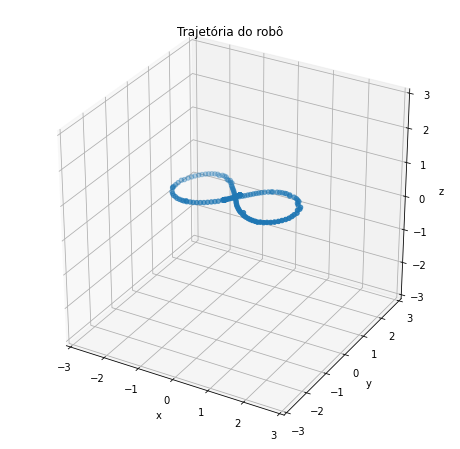

In [11]:
# Plot
ax0 = set_plot()
path = path[0:3,:]
ax0.scatter(path[0,:], path[1,:], path[2,:])

plt.show()